We deployed [the new M-Lab platform to 1/3rd of the M-Lab fleet](http://example.com), and now we
need to assess whether or not it is a performance regression, relative to the
old platform.  As long as we can be sure the performance of the new platform
does not constitute a regression, then we can roll out the new platform to
2/3rds of the fleet, redo this analysis in a pro-forma way to make sure nothing
has gone wrong after the 1/3rd to 2/3rds rollout, and then roll out the new
platform to the remaining nodes around the world.

More concretely, for every site, we would like to be certain, at the 95% level
or above, that the performance data gathered on the new platform is not worse
(lower bandwidth, higher latency) than the old platform at that same site.

We are in a situation that is an almost textbook case for statistical analaysis:
1. We have a lot of data
2. We have a question of interest (is the new platform at least as performant as
   the old platform?)
3. We have a default action (roll out the new platform to 2/3rds of the fleet)

In developing an analysis, we want to be congnizant of a few important facts:
1. Internet performance is differently variable in different regions of the
   world.
2. Not all machines at a site are used equally. In particular, we know of some
   NDT clients which will ONLY run a test to `ndt.iupui.mlab1.lax03` and would
   never run a test to `ndt.iupui.mlab2.lax03` or `ndt.iupui.mlab3.lax03`.
3. The kubernetes platform is not rolled out to any `mlab1` machines.

Our needs and our constraints lead to the following per-site analysis method to
decide whether the new platform is not a regression at a given site:

Let us assume that for this site, the `mlab2` machine uses PlanetLab, vservers,
and web100 (a PL machine) and the `mlab3` machine uses Kubernetes, Docker, and tcp-info (a k8s machine).
1. Calculate the mean and median download, upload, and latency experienced by
   all NDT clients that connected to `mlab2` or `mlab3` during the month of
   September.  If the mean and median for the new platform are both not worse
   than the mean and median for the old platform, then we are done.  The
   performance of the new platform at that site does not constitute a
   regression.
2. If either of the mean or median upload speed, download speed, or RTT have
   regressed, then we calculate a "noise floor" for the site by doing the same
   analysis for January, February, ..., June of 2019.  During those months, all
   the `mlab3` machines were controlled by the old platform and as such, our
   monthly variation between sample means establishes a "noise floor".  We then
   compare the new difference (between the new and old) to the established noise
   floor (between the old and the old) to see whether it is within historical
   norms.  If we are 95% confident that the new performance differential is
   within historical norms, then we can conclude that the new performance at the
   site does not constitue a regression.
3. If the regression in performance is outside of historical norms, we conduct
   an investigation to discover why.

Armed with this analysis method, we set about investigating M-Lab's Bigquery NDT
data.  We begin by calculating a maximum per-client performance to each machine
at the site, to prevent any
individual network endpoint from contributing too much to the final analysis.
We then compare the mean and median of these "monthly bests" between the PL and
k8s.

We first begin by constructing a basic query that filters out some bad-looking data and then creates two joinable tables containing per-site performance at the 0%, 10%, ... 90%, and 100% levels as well as per-site average performance.  Once we have both of these, we conduct two analyses: a visual one and a quantitative one.

In [22]:
from google.cloud import bigquery
client = bigquery.Client(project='measurement-lab')
# ADD DURATION TO THE QUERIES
summary_tables = '''with 
pl_performance_multiples as (
  SELECT test_id, 
    connection_spec.server_hostname as host, 
    connection_spec.client_ip as client,
    8 * (web100_log_entry.snap.HCThruOctetsAcked / (web100_log_entry.snap.SndLimTimeRwin + web100_log_entry.snap.SndLimTimeCwnd + web100_log_entry.snap.SndLimTimeSnd)) as bandwidth_down
  FROM `measurement-lab.ndt.web100`
  WHERE connection_spec.server_hostname NOT LIKE '%mlab1%'
  AND partition_date BETWEEN DATE("2019-09-01") AND DATE("2019-10-01")
  AND (web100_log_entry.snap.SndLimTimeRwin + web100_log_entry.snap.SndLimTimeCwnd + web100_log_entry.snap.SndLimTimeSnd) / 1000000.0 BETWEEN 9 and 13
  AND web100_log_entry.connection_spec.local_ip IS NOT NULL
  AND web100_log_entry.connection_spec.remote_ip IS NOT NULL
  AND web100_log_entry.connection_spec.remote_ip NOT IN(
    "45.56.98.222", "35.192.37.249", "35.225.75.192",
    "2600:3c03::f03c:91ff:fe33:819", "23.228.128.99", "2605:a601:f1ff:fffe::99")
  -- Download direction, and at least 8KB transfered
  AND connection_spec.data_direction IS NOT NULL
  AND connection_spec.data_direction = 1
  AND web100_log_entry.snap.HCThruOctetsAcked IS NOT NULL
  AND web100_log_entry.snap.HCThruOctetsAcked >= 8192
  -- Sum of SndLimTime* have real values.
  AND web100_log_entry.snap.SndLimTimeRwin IS NOT NULL
  AND web100_log_entry.snap.SndLimTimeCwnd IS NOT NULL
  AND web100_log_entry.snap.SndLimTimeSnd IS NOT NULL
),
pl_performance as (
  SELECT * EXCEPT(row_number) FROM (
    SELECT *, ROW_NUMBER() OVER (PARTITION BY CONCAT(host, client) ORDER BY FARM_FINGERPRINT(download_mbps)) AS row_number FROM merged)
  WHERE row_number = 1
),
pl_summaries as (
  SELECT regexp_extract(host, r"mlab[0-9]\.([^.]*)\.measurement-lab.org") as site, AVG(bandwidth_down) as pl_mean_mbps, approx_quantiles(bandwidth_down, 100) as pl_deciles
  FROM pl_performance
  GROUP BY host
),
k8s_performance as (
  SELECT MAX(result.S2C.MeanThroughputMbps + .032) as bandwidth_down, REPLACE(REGEXP_EXTRACT(ParseInfo.TaskFileName, "-(mlab[1-4]-[a-z]{3}[0-9]{2})-"), "-", ".") AS host, result.ClientIP as client
  FROM `measurement-lab.ndt.ndt5`
  WHERE DATE(result.StartTime) BETWEEN DATE("2019-09-01") AND DATE("2019-10-01")
  AND TIMESTAMP_DIFF(S2C.EndTime, S2C.StartTime, MILLISECOND)/1000 BETWEEN 9 AND 13
  AND result.S2C IS NOT NULL
  AND result.S2C.ClientIP IS NOT NULL
  AND result.S2C.ClientIP NOT IN(
    "45.56.98.222", "35.192.37.249", "35.225.75.192",
    "2600:3c03::f03c:91ff:fe33:819", "23.228.128.99", "2605:a601:f1ff:fffe::99")
  --AND result.S2C.MeanThroughputMbps > 0
  GROUP BY host, client
),
k8s_summaries as (
  SELECT regexp_extract(host, r"mlab[0-9]\.([^.]*)") as site, AVG(bandwidth_down) as k8s_mean_mbps, approx_quantiles(bandwidth_down, 100) as k8s_deciles
  FROM k8s_performance
  GROUP BY host
) '''

In [23]:
deciles_query = summary_tables + ''',
pl_unnested as (
  SELECT site, pl_mbps, offset
  FROM pl_summaries CROSS JOIN UNNEST(pl_summaries.pl_deciles) AS pl_mbps WITH OFFSET AS offset
),
k8s_unnested as (
  SELECT site, k8s_mbps, offset
  FROM k8s_summaries CROSS JOIN UNNEST(k8s_summaries.k8s_deciles) AS k8s_mbps WITH OFFSET AS offset
)

SELECT site, offset as decile, k8s_mbps, pl_mbps
FROM pl_unnested INNER JOIN k8s_unnested USING (site, offset)
'''

from collections import defaultdict as dd
data = dd(lambda: dd(lambda: [0 for _ in range(101)]))

for row in client.query(deciles_query):
    data[row['site']]['pl'][row['decile']] = row['pl_mbps']
    data[row['site']]['k8'][row['decile']] = row['k8s_mbps']


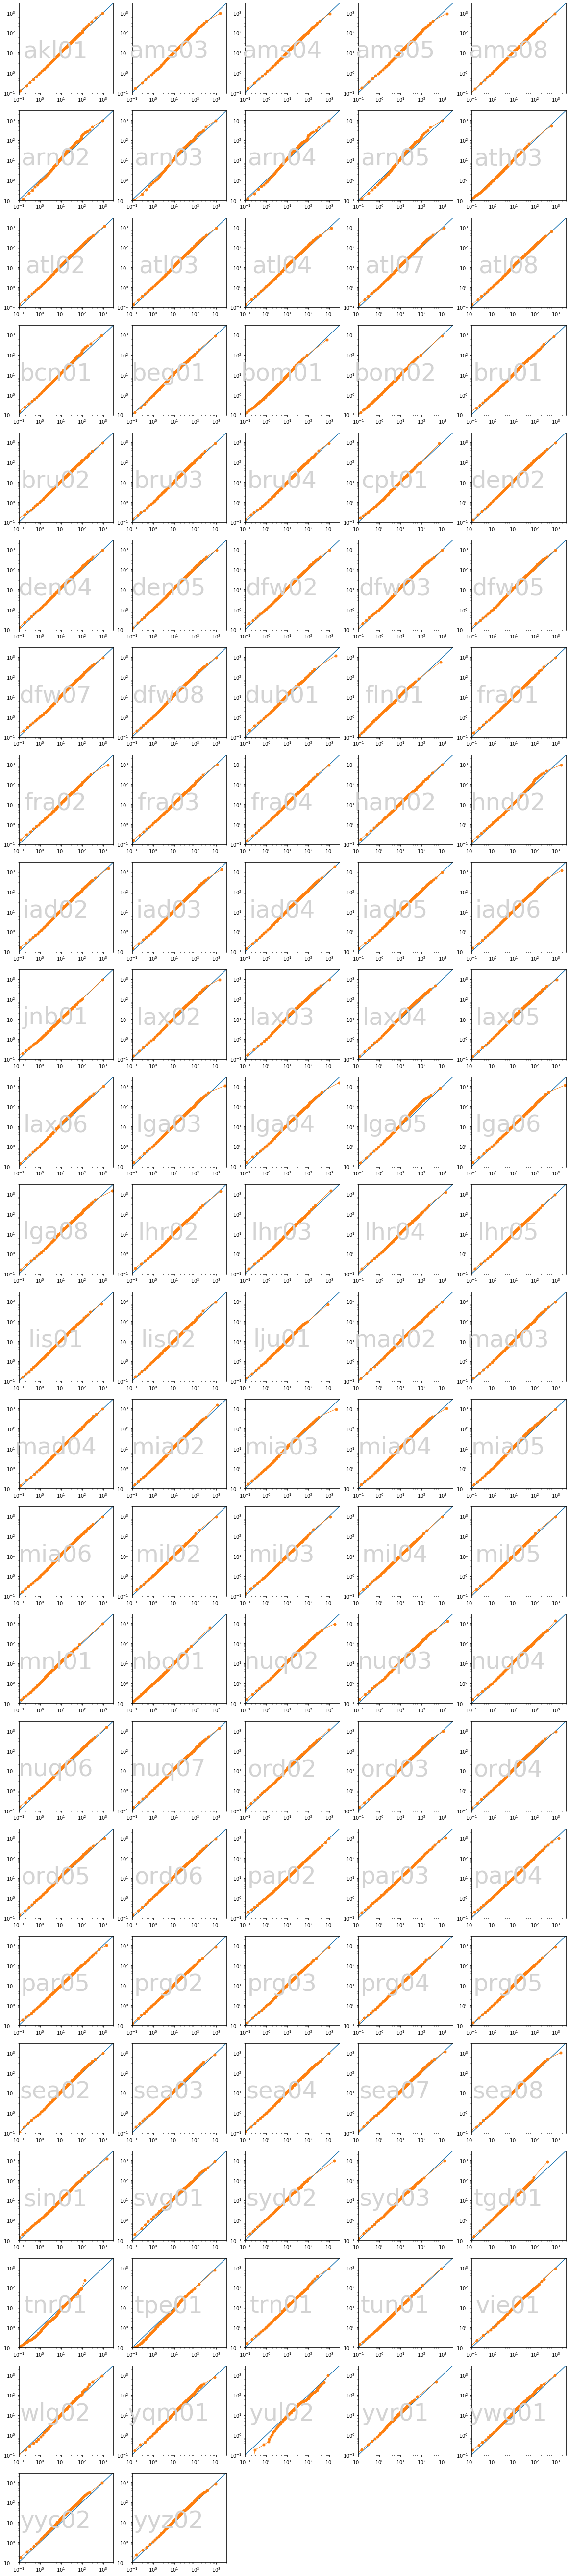

In [21]:
%matplotlib inline
import math
import matplotlib.pyplot as plt
columns = 5
rows = math.ceil(len(data) / float(columns))
plt.rcParams['figure.figsize'] = [20,4*rows]
for i, site in enumerate(sorted(data)):
    plt.subplot(rows, columns, i+1)
    top = 3000
    plt.loglog(range(int(top+2)), range(int(top+2)), label="preferred")
    plt.text(top**.5/10, top**.5/10, site, ha='center', fontsize=48, color='lightgray')
    plt.loglog(data[site]['pl'], data[site]['k8'], label=site, linewidth=1, marker=".", markersize=10)
    plt.xlim(left=.1, right=3000)
    plt.ylim(bottom=.1, top=3000)
    
plt.show()